## EOF Analysis of Sea Level Pressure data in Python

In this file I read an NCAR dataset of gridded analysis of Sea Level Pressure (SLP), retrieved from https://climatedataguide.ucar.edu/climate-data/ncar-sea-level-pressure.

The SLP data is a NetCDF file on a 5° grid of latitude/longitude and covers 30°-90°N, containing monthly mean values of SLP. I have selected data from 1950-2020.

I read the data using xarray, find climatology and anomalies, and then feed the data into an EOF analysis solver function from 
https://github.com/ajdawson/eofs. I then plot the EOF using cartopy.


Packages used: 
1. xarray for reading in the NetCDF file data and working with multi_dimensional coord data and preserves metadata
2. numpy
3. eofs to perform the EOF analysis on the xarray data - https://github.com/ajdawson/eofs
4. scipy for performing a low pass filter on time series data
5. cartopy for plotting on a map projection
6. matplotlib


### Why EOF?

EOF (Empirical Orthogonal Function) Analysis is valuable tool in studying Meteorology and Climate in order to investigate patterns of variability in large datasets. The EOFs essentially compress the data into the most dominant patterns of spatial variability.

In this analysis I focus on western Europe and the North Atlantic region. Thus the most common pattern of variability (leading EOF) should resemble the North Atlantic Oscillation (NAO).


### Getting started

First I import the necessary packages:


In [3]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from eofs.xarray import Eof
from scipy.signal import butter,filtfilt

Now I read in the NetCDF data file using `xarray` and call the coords of the data (lat, lon, time).

In [4]:
datafile = 'ds010.1.19500100.20200331.nc'

#Open the dataset and print out info
ds = xr.open_dataset(datafile)
print(ds)

lat = ds["lat"]
slp = ds["slp"]
time = ds["time"]

<xarray.Dataset>
Dimensions:    (lat: 16, lon: 72, time: 843)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01T12:00:00 ... 2020-03-02T07:00:00
  * lat        (lat) int32 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90
  * lon        (lon) int32 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
Data variables:
    date_time  (time) int32 ...
    slp        (time, lat, lon) float32 ...


### Reassign longitude coordinates

For the longitude, the coordinate system is defined 0-360. The region I want to analyse is from 60W to 30E (or -60 to 30). In the slp coord system this is 300 to 30. At first I selected the slp data using `sel` to index and or `|`:

`slp.sel(lon=(slp.lon < 31) | (slp.lon > 299))`

This worked fine for the eof analysis. However, issues arose when it came to plotting with cartopy due to the handling of the coord system.

Instead it was much more straightforward to reassign the longitude coordinates to -180 to 180:

In [5]:
slp = slp.assign_coords(lon=(((slp.lon + 180) % 360) - 180)).sortby('lon')

#Select the subset of data: lon -60 to 30
slp = slp.sel(lon = slice(-60, 30))
lon = slp["lon"]

### Calculating seasonal anomalies - DJF

I now have to calculate the winter (Dec, Jan, Feb) climatology (mean) and the anomalies for each winter in the data period (1950-2020).

One problem with calculating a mean for each winter is that Dec is in the previous year from Jan and Feb which makes grouping harder.





To group winter months together, I first selected only winter months and made other months null using:

`slp.where(slp['time.season'] == 'DJF'`

In [6]:
slp_DJF = slp.where(slp['time.season'] == 'DJF')

#check output at point for first 16 months
print(slp_DJF.sel(lat=50,lon=0).isel(time = slice(None, 16)))

<xarray.DataArray 'slp' (time: 16)>
array([1022.6, 1010. ,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan, 1009.5, 1009.1, 1003.6,    nan,    nan],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 1951-04-01T12:00:00
    lat      int32 50
    lon      int32 0
Attributes:
    standard_name:  air_pressure_at_sea_level
    long_name:      sea level pressure
    units:          hPa


This then allows each winter to be grouped together and an average found using `xarray.rolling`. 

Setting the window to `time=3` points, `min_periods = 3` and `center = True` means an average is found where there are three consecutive non null months in slp_DJF and is placed in the January time coord for each year. 


Depending on the data range, this means some data will be dropped - here the data runs from 1950-01 to 2020-03 so the first winter value will be null.

Grouping the resultant array by `"time.year"` and averaging over each year finally returns the annual DJF means.

In [7]:
slp_DJF = slp_DJF.rolling(min_periods=3, center=True, time=3).mean()

# make annual mean for each winter
slp_DJF = slp_DJF.groupby('time.year').mean('time')
print(slp_DJF.sel(lat=50,lon=0).isel(year=slice(None, 16)))

<xarray.DataArray 'slp' (year: 16)>
array([       nan, 1007.4    , 1017.2667 , 1018.8667 , 1017.3    ,
       1010.23334, 1015.93335, 1016.93335, 1014.10004, 1017.4    ,
       1009.5334 , 1014.5668 , 1018.1667 , 1016.8334 , 1022.06665,
       1018.1667 ], dtype=float32)
Coordinates:
    lat      int32 50
    lon      int32 0
  * year     (year) int64 1950 1951 1952 1953 1954 ... 1961 1962 1963 1964 1965


The climatology `DJF_climo` is then the mean across the time series, and the anomalies are the djf annual values `slp_DJF` minus the mean.

I then drop the null first year 1950, and rename the coordinate from `year` back to `time`.

In [8]:
#average over time to get climatology and subtract for anomalies
DJF_climo = slp_DJF.mean(dim="year")
DJF_anoms = slp_DJF - DJF_climo

yr_max = DJF_anoms["year"].max().values
yr_min = DJF_anoms["year"].min().values +1  #in this case the last year is kept
DJF_anoms = DJF_anoms.sel(year = slice(yr_min,yr_max))

DJF_anoms = DJF_anoms.rename({"year":"time"})

### Performing the EOF Analysis

With the anomalies the EOF analysis can now be conducted.

An important step in the analysis is to apply latitude weights (of the square root of cosine of latitude) to the data to ensure an equal contribution from different latitudes (high latitude data is more dense).

Using the `eofs` package https://github.com/ajdawson/eofs by `ajdawson`, I then use the `EOF` function to compute the EOF and associated PC time series.

I then extract the leading EOF (neofs=1), with corresponding PC and Variance. The resultant map was reversed to the sign of the NAO so I multipled both by -1 to flip the sign. 


In [9]:
coslat = np.cos(np.deg2rad(lat.values))    #cosine of the latitude values

wgts = np.sqrt(coslat)[..., np.newaxis]    #latitiude weights to apply

solver = Eof(DJF_anoms, weights=wgts)      #read the anomalies data and weights into the EOF solver


#Extract the leading EOF, expressed as the correlation between the leading
#PC time series and the input DJF slp anomalies at each lat/lon point.

eof1 = solver.eofsAsCorrelation(neofs=1)
eof1 = eof1*-1                             # Here I flipped the sign of the eof to align with sign of NAO


#Find the leading EOF PC time series and the variance explained by the leading EOF
pc1 = solver.pcs(npcs=1, pcscaling=1)      #pscaling of 1 means the PC and eof will be standardised
pc1 = pc1*-1                               #flip sign to match eof sign
var = solver.varianceFraction(neigs = 1)

### Low pass filter

On the PC time series, I then applied a low pass filter in order to visualise the smoothed trends through time.

For this I used the following implementation described on medium <a href="https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7" target="_blank">how to filter noise with a low pass filter</a> with the `butter` and `filtfilt` functions from `scipy`

In [10]:
fs = 1.0                    # sample rate of the data, here 1 value per year
cutoff = 1/6                # desired cutoff frequency of the filter: here I cut off freqs greater than 1/6 per yr
nyq = 0.5 * fs              # Nyquist Frequency
order = 5                   

def low_pass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Insert filter variables and choose low pass
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    lpf = filtfilt(b, a, data)
    return lpf

lpf = low_pass_filter(pc1[:,0], cutoff, fs, order)

### Finally Plot the EOF and PC Time Series

I then plotted the EOF spatial map using `cartopy` for map projection.

For the PC time series and low pass filter, I used matplotlib and created a bar and line plot.

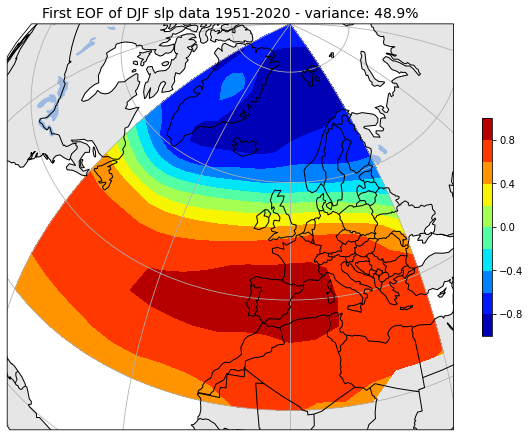

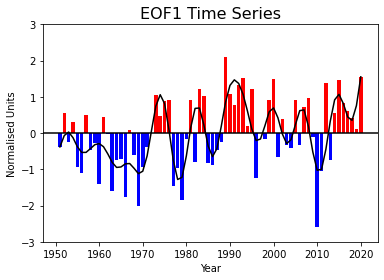

In [11]:
def Plot_map():
    #create map projection on which to plot EOF
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=50.0)
    fig, ax = plt.subplots(subplot_kw = dict(projection = proj), figsize=(10,8))
    
    
    #add map features
    ax.add_feature(cfeature.LAND, facecolor = "0.9")
    ax.add_feature(cfeature.LAKES, alpha = 0.9)
    ax.add_feature(cfeature.BORDERS, zorder=10)
    ax.add_feature(cfeature.COASTLINE, zorder=10)
    
    ax.gridlines()
    
    return fig, ax

fig, ax = Plot_map()

#set countour levels for the contour plot of the EOF 
clevs = np.linspace(-1, 1, 11)

eof_contour = ax.contourf(lon, lat, eof1[0], cmap=plt.cm.jet, levels = clevs, zorder=2, transform = ccrs.PlateCarree())

#Create a colourbar for the plot
cb = plt.colorbar(eof_contour, shrink=0.5)

ax.set_title(f'First EOF of DJF slp data {yr_min}-{yr_max} - variance: {var[0].values*100:.1f}%', fontsize=14)

#Plot the leading PC time series.
plt.figure()

ax = plt.gca()
ax.bar(pc1.time.values, pc1[:, 0].values, 
       color = list(map(lambda x: "r" if x>0 else "b", pc1[:,0].values)))
ax.plot(pc1.time.values, list(lpf), color = "k")
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalised Units')
ax.set_title('EOF1 Time Series', fontsize=16)

plt.show()


### Results

The plot of the leading EOF shows a clear pattern of covariability in sea level pressure over the North Atlantic region. Looking at the associated PC time series, the amplitude of the pattern with time is seen (negative or positive). 

This pattern resembles the North Atlantic Oscillation which is the dominant pattern of variability in this region (<a href="https://www.ncdc.noaa.gov/teleconnections/nao/" target="_blank">NOAA</a>, <a href="https://onlinelibrary.wiley.com/doi/abs/10.1002/wcc.150" target="_blank">Pinto and Raible, 2011</a>). Climatologically in winter (DJF), low pressure sits close to Iceland, while high pressure lies near the Azores. During a positive NAO phase, pressure is lower than averge over Iceland and higher than average near the Azores - thus the pattern is strengthened. This tends to bring anomalously mild, wet condtions to western Europe with a more zonal flow and stronger west/south-westerly winds, along with more frequent lows moving across the Atlantic. 

Conversely, during a negative phase, pressure is higher than average over Iceland and lower than average near the Azores. This brings a weakened pattern, with a greater chance of northerly or easterly winds in Europe which bring colder and drier conditions in winter.

The PC shows the predominantly negative NAO winters during the 50s and 60s, becoming variable during the 70s and 80s. From the 90s onwards, a switch to a positive phase is observed.

The 2009/2010 winter stands out, with studies showing it to have been one of the strongest negative NAO winters in the last 150 years (Reference). During this winter, anomalously easterly winds brought extended cold conditions to Europe, along with persistent snow (<a href="http://dx.doi.org/10.1029/2011GL046786" target="_blank">Jung et al., 2011</a>).

Strong positive winters are seen in both 2015/16 and 2019/20. The winter of 19/20 was the fifth warmest in a series from 1884 and the fifth wettest since 1862 (<a href="https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/weather/learn-about/uk-past-events/summaries/uk_monthly_climate_summary_winter_2020.pdf" target="_blank">Met Office</a>), and saw a persistent zonal flow, enhanced by a strong polar vortex (<a href="https://doi.org/10.1002/asl.1005" target="_blank">Hardiman et al., 2020</a>). 

Meanwhile the winter of 2015/16 saw the mildest December by a large margin ever recorded across the UK in a series from 1910 and in the Central England series from 1659 (<a href="https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/weather/learn-about/uk-past-events/interesting/2015/exceptional-warmth-december-2015---met-office.pdf" target="_blank">Met Office</a>, <a href="https://doi.org/10.1002/wea.2823" target="_blank">McCarthy et al., 2016</a>). Severe flooding also affected parts of the UK in December, while overall the winter was the third wettest in the series from 1910 (<a href="https://digital.nmla.metoffice.gov.uk/IO_dcca9674-7eaf-4df6-a3d5-5510482cd269/" target="_blank">Met Office, 2016</a>).

### Conclusion

The EOF analysis of the SLP data produced a clear spatial pattern which was an effective visualisation of the NAO. Further analyses which could be performed for more insight would be to perform linear regression of different meteorological variables (e.g. surface temperature, wind vectors, vertical velocity) onto the EOF PC time series. The regression coefficient could then be plotted for each grid point and only statistically significant values plotted in order to illustrate the relation of the NAO SLP pattern with other variables.